# Deep Learning - Exercise 6

The aim of the lecture is to learn how to use recurrent neural networks (RNN) for text data analysis, specifically focusing on sentiment analysis tasks using Twitter data.

**Core Concepts**
* 🧠 Recurrent neural networks for sequence processing
* 📝 Sentiment analysis of textual data
* 🐦 Twitter dataset utilization
* 🔤 GloVe embeddings for word representation
* 📊 Text classification by sentiment

You can download the dataset from [this link](https://github.com/MohamedAfham/Twitter-Sentiment-Analysis-Supervised-Learning/tree/master/Data)

[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_06.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_06.ipynb)

##### Remember to set **GPU** runtime in Colab!

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

from sklearn.model_selection import train_test_split  #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize
import scipy
import itertools
import os
import time

tf.version.VERSION

2025-03-29 15:25:20.526398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743258320.541259   27981 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743258320.545051   27981 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-29 15:25:20.559005: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.18.0'

# 📒 We will work with LSTM/GRU layers
* 🔎Do you know anything abour RNN in general?
    * How are they different from FCNN?

![Meme02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_06_meme_02.png?raw=true)

* How is pure RNN and LSTM/GRU layer different?
    * 🔎 What issue of RNN do they address?
* Can you imagine some use-cases for RNN?
    * Can you imagine some limits of ML/DL solutions in the usecases as well?

## 🔎 We have some new packages today 🔎
* Below is a short description of them, check out the URLs for more details and API 

### 📌 NLTK
* NLTK is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries, and an active discussion forum.
    * https://www.nltk.org/

### 📌 TextBlob
* TextBlob is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.
    * https://textblob.readthedocs.io/en/dev/

In [2]:
import unicodedata, re, string
import nltk
from textblob import TextBlob

import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

In [3]:
# Download NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/vojte/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vojte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vojte/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

## Punkt Sentence Tokenizer
* 🔎 Why do we use tokenizers?
* This tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences. 
    * It must be trained on a large collection of plaintext in the target language before it can be used.

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/vojte/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Download the dataset

In [6]:
df = pd.read_csv('https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/raw/main/datasets/train_tweets.csv')

# ⚡ Let's take a look at the data

In [7]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [8]:
df.shape

(31962, 3)

<Axes: xlabel='label', ylabel='count'>

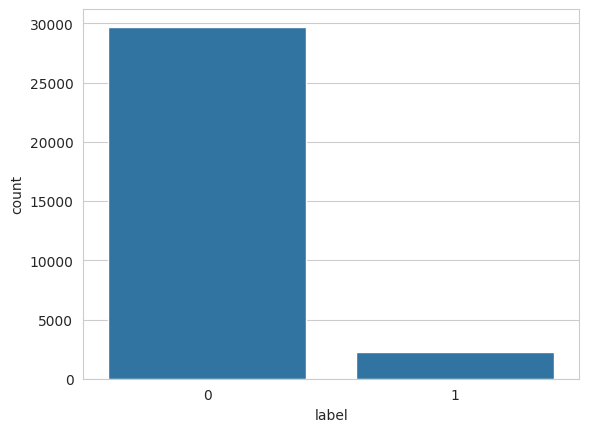

In [9]:
sns.countplot(x='label', data=df)

In [10]:
df.label.value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

## We can see that the classes are highly imbalanced, because we have only 2242 negative tweets compared to positive ones number
* 🔎 What will be impacted by class imbalance?

### 💡 We can see that sentences are of similar length regardless the class

In [11]:
df['length'] = df.tweet.apply(len)

<Axes: xlabel='label', ylabel='length'>

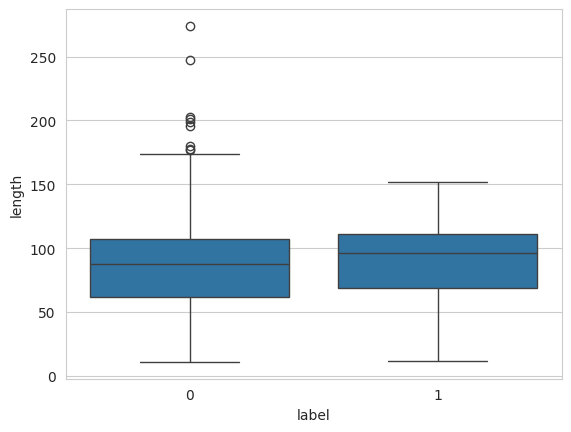

In [12]:
sns.boxplot(x='label', y='length', data=df)

## We can see that the text data are full of noise

* 💡 Social posts suffer the most from this effect
    * The text is full of hashtags, emojis, @mentions and so on
    * These parts usually don't influence the sentiment score much
* 💡 Although most advanced models usually extract even this features because e.g. emojis can help you with the sarcasm understanding

## Take a look at few examples, it will share many of these caveates which we've just discussed

In [13]:
for x in df.loc[:10, 'tweet']:
    print(x, '\n', '-' * len(x))

 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run 
 ------------------------------------------------------------------------------------------------------
@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked 
 --------------------------------------------------------------------------------------------------------------------------
  bihday your majesty 
 ---------------------
#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦   
 --------------------------------------------------------------------------------------
 factsguide: society now    #motivation 
 ---------------------------------------
[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo   
 --------------------------------------------------------------------------------------------------------------------
 @us

# 📒 We have a few specific pre-processing techniques for the text data
* 💡 Benefits of using these techniques varies from approach to approach
    * However it is good to have at least some knowledge about them

## Stemming
* Stemming is the process of producing morphological variants of a root/base word
    * Stemming programs are commonly referred to as stemming algorithms or stemmers
* 💡 A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”

#### ⚡ Examples of stemming:
* chocolates, chocolatey, choco : **chocolate**
* retrieval, retrieved, retrieves : **retrieve**


## Lemmatization 
* Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item
* 💡 Lemmatization is similar to stemming but it brings context to the words
    * 💡 It links words with similar meaning to one word

#### ⚡ Examples of lemmatization:
* rocks : **rock**
* corpora : **corpus**
* better : **good**

### Both techiques can be used in the preprocessing pipeline
* You have to decide if it is beneficial to you, because this steps leads to generalization of the data by itself
    * 💡 You will definitely lose some pieces of the information!

# 📌 Embedding note
* **If you use some form of embedding like Word2Vec or Glove, it is better to skip this steps because during the embedding vocabulary building process it was skipped as well** 🙂

# You don't have to code the pre-process steps yourself 🙂
* We have already prepared the most common functions used
    * 💡 Modify function `normalize(...)` for different step combination

In [14]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words


def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words


def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words


def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems


def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas


def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    # words = remove_punctuation(words)
    words = remove_numbers(words)
    #    words = remove_stopwords(words)
    return words


def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    return tweet_blob.words

<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_27981/3355288462.py:33: SyntaxWarning: invalid escape sequence '\d'
  new_word = re.sub("\d+", "", word)


# First we must tokenize sentences and remove puncuation 
* We will use the `TextBlob` library

In [15]:
!python -m textblob.download_corpora

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: line 1: python: command not found


In [16]:
df['Words'] = df['tweet'].apply(form_sentence)

In [17]:
df.head()

,id,label,tweet,length,Words
0,1,0,@user when a father is dysfunctional and is s...,102,"[user, when, a, father, is, dysfunctional, and..."
1,2,0,@user @user thanks for #lyft credit i can't us...,122,"[user, user, thanks, for, lyft, credit, i, ca,..."
2,3,0,bihday your majesty,21,"[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,86,"[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,39,"[factsguide, society, now, motivation]"


# Normalize sentences 
* We want only ascii and lowercase characters and we also want to get rid of numbers in the strings

### You can always experiments with different preprocessing steps! 🙂
* 💡 The steps choice usually depends on the dataset

In [18]:
df['Words_normalized'] = df['Words'].apply(normalize)

In [19]:
df.head()

,id,label,tweet,length,Words,Words_normalized
0,1,0,@user when a father is dysfunctional and is s...,102,"[user, when, a, father, is, dysfunctional, and...","[user, when, a, father, is, dysfunctional, and..."
1,2,0,@user @user thanks for #lyft credit i can't us...,122,"[user, user, thanks, for, lyft, credit, i, ca,...","[user, user, thanks, for, lyft, credit, i, ca,..."
2,3,0,bihday your majesty,21,"[bihday, your, majesty]","[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,86,"[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,39,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]"


## Remove the 'user' word from tweets

In [20]:
df['Words_normalized_no_user'] = df['Words_normalized'].apply(lambda x: [y for y in x if 'user' not in y])

In [21]:
df.head()

,id,label,tweet,length,Words,Words_normalized,Words_normalized_no_user
0,1,0,@user when a father is dysfunctional and is s...,102,"[user, when, a, father, is, dysfunctional, and...","[user, when, a, father, is, dysfunctional, and...","[when, a, father, is, dysfunctional, and, is, ..."
1,2,0,@user @user thanks for #lyft credit i can't us...,122,"[user, user, thanks, for, lyft, credit, i, ca,...","[user, user, thanks, for, lyft, credit, i, ca,...","[thanks, for, lyft, credit, i, ca, n't, use, c..."
2,3,0,bihday your majesty,21,"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,86,"[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,39,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, now, motivation]"


## 💡 We can see that no pre-processing is ideal and we have to fix some issues by ourselves
* e.g. n't splitting

In [22]:
print(df.tweet.iloc[1])
print(df.Words_normalized_no_user.iloc[1])

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
['thanks', 'for', 'lyft', 'credit', 'i', 'ca', "n't", 'use', 'cause', 'they', 'do', "n't", 'offer', 'wheelchair', 'vans', 'in', 'pdx', 'disapointed', 'getthanked']


In [23]:
def fix_nt(words):
    st_res = []
    for i in range(0, len(words) - 1):
        if words[i + 1] == "n't" or words[i + 1] == "nt":
            st_res.append(words[i] + ("n't"))
        else:
            if words[i] != "n't" and words[i] != "nt":
                st_res.append(words[i])
    return st_res

In [24]:
df['Words_normalized_no_user_fixed'] = df['Words_normalized_no_user'].apply(fix_nt)

## ⚡ The issue is now fixed

In [25]:
print(df.tweet.iloc[1])
print(df.Words_normalized_no_user.iloc[1])
print(df.Words_normalized_no_user_fixed.iloc[1])

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
['thanks', 'for', 'lyft', 'credit', 'i', 'ca', "n't", 'use', 'cause', 'they', 'do', "n't", 'offer', 'wheelchair', 'vans', 'in', 'pdx', 'disapointed', 'getthanked']
['thanks', 'for', 'lyft', 'credit', 'i', "can't", 'use', 'cause', 'they', "don't", 'offer', 'wheelchair', 'vans', 'in', 'pdx', 'disapointed']


## Now we can join the text into single string again for each instance

In [26]:
df['Clean_text'] = df['Words_normalized_no_user_fixed'].apply(lambda x: " ".join(x))

In [27]:
df['Clean_text'].head()

0    when a father is dysfunctional and is so selfi...
1    thanks for lyft credit i can't use cause they ...
2                                          bihday your
3           model i love u take with u all the time in
4                               factsguide society now
Name: Clean_text, dtype: object

# 🚀 Let's take a look at the most common words in corpus
* It is one of the usual EDA step for text data
    * ⚠ Without the preprocessing there will be a lot of so-called *stopwords*

## 🔎 Do you know what the term **stopword** mean?

## Step 1: Tokenize each string and merge the token array into one big array using `itertools.chain()`

In [28]:
all_words = list(itertools.chain(*df.Words_normalized_no_user_fixed))

In [29]:
all_words[:20]

['when',
 'a',
 'father',
 'is',
 'dysfunctional',
 'and',
 'is',
 'so',
 'selfish',
 'he',
 'drags',
 'his',
 'kids',
 'into',
 'his',
 'dysfunction',
 'thanks',
 'for',
 'lyft',
 'credit']

## Step 2: Compute frequency of every token using `nltk`

In [30]:
dist = nltk.FreqDist(all_words)

## 💡 The most common tokens are:

In [31]:
dist

FreqDist({'the': 10136, 'to': 9798, 'a': 7680, 'i': 7165, 'you': 5679, 'and': 4868, 'in': 4615, 'for': 4462, 'of': 4133, 'is': 4048, ...})

## 💡 We have 34289 unique words (tokens)

In [32]:
len(dist)

34292

## 💡 The longest tweet has 42 tokens

In [33]:
max(df.Words_normalized_no_user_fixed.apply(len))

42

# 🚀 Our dataset is ready, we can start our Deep learning experiments 
* 🔎 Can you use regular FCANN for the sentiment analysis?

![Meme01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_06_meme_01.png?raw=true)


# We will use `TextVectorization` layer for creating vector model from our text data
* For those of you who are interested in the topic there is very good [article on Medium](https://towardsdatascience.com/you-should-try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee) about the layer and its parameters
    * There is of course a [documentation page](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) about the layer as well

## 🔎 What does *text vectorization* mean in this context?
* Is it a different term from the one used in information retrieval?

## 📌 There are few important parameters:
* `emedding_dim` 
    * Dimension of embedded representation
    * This is already part of latent space, there is captured dependecy among words in these vectors, we are learning this vectors using the ANN
* `vocab_size`
    * Number of unique tokens in vocabulary
* `sequence_length`
    * Output dimension after vectorizing - words in vectorized representation are treated as independent

In [34]:
embedding_dim = 128  # Dimension of embedded representation
vocab_size = 10000  # Number of unique tokens in vocabulary
sequence_length = 30  # Output dimension after vectorizing

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Clean_text.values)

I0000 00:00:1743258333.853176   27981 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


## We will split our dataset to train and test parts with stratification

## 🎯 COMPETITION TEST SET HERE 🎯

### COMPETITION ?!?! 🤔
* I will provide the details in the end of the lecture 🙂

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.Clean_text, df.label, test_size=0.20, random_state=13,
                                                    stratify=df.label)

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=13,
                                                      stratify=y_train)

In [37]:
print(X_train.shape, X_test.shape)

(23012,) (6393,)


In [38]:
print('Train')
print(y_train.value_counts())
print('Test')
print(y_test.value_counts())

Train
label
0    21397
1     1615
Name: count, dtype: int64
Test
label
0    5945
1     448
Name: count, dtype: int64


In [39]:
print('Vocabulary example: ', vect_layer.get_vocabulary()[:10])
print('Vocabulary shape: ', len(vect_layer.get_vocabulary()))

Vocabulary example:  ['', '[UNK]', np.str_('the'), np.str_('to'), np.str_('a'), np.str_('i'), np.str_('you'), np.str_('and'), np.str_('in'), np.str_('for')]
Vocabulary shape:  10000


# 🚀 Let's finally try the RNN-based model!

In [40]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = LSTM(64, activation='relu', return_sequences=True)(emb)
x = GRU(64, activation='relu', return_sequences=False)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()
# keras.metrics.F1Score(average='weighted',threshold=0.5, name='f1') - currently bugged
model.compile(optimizer=keras.optimizers.AdamW(), loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy(name='accuracy')])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 30)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 30, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,360,641 (5.19 MB)

 Trainable params: 1,360,641 (5.19 MB)

 Non-trainable params: 0 (0.00 B)

## We are using `AdamW` optimizer, which is a variant of Adam optimizer ⚙️
### Adam Optimizer 🧠

Adam (Adaptive Moment Estimation) combines two key techniques to improve neural network training:

- **Momentum** 🔄: Keeps track of previous directions, helping navigate tricky optimization landscapes like a ball rolling downhill
- **Adaptive learning rates** 📊: Adjusts the step size individually for each parameter based on its history

Adam is memory-efficient and works well for smaller networks, simple regression problems, and when working with clean datasets

**Adaptive Learning Rates in Adam: A Simple Explanation** 🧭

* Imagine you're hiking through mountains with varying terrain - steep cliffs, gentle slopes, and flat meadows 🏔️
* The "adaptive learning rates" in Adam work like an intelligent hiking assistant that helps you navigate this landscape efficiently

**How It Works** ⚙️

1. **Different Parameters Need Different Step Sizes** 📏
   - Some parameters might need big updates (steep terrain) 📈
   - Others might need tiny, careful updates (slippery slopes) 📉

2. **Adam Keeps Track of History** 📜
   - For each parameter, Adam remembers how much that parameter has changed recently
   - If a parameter has been changing a lot, Adam gives it smaller updates ⬇️
   - If a parameter has barely moved, Adam gives it larger updates ⬆️

3. **Real-World Example** 🌍
   - Parameter A has seen huge gradients (values like 10.0, 8.5, 9.2)
   - Parameter B has seen tiny gradients (values like 0.01, 0.02, 0.01)
   - With a fixed learning rate, A would move too quickly and B too slowly ⚠️
   - Adam automatically gives A smaller steps and B larger steps ✅

**Why This Matters** 💡

- **Prevents Oscillation** 🔄: Parameters that tend to bounce back and forth get smaller updates
- **Escapes Flat Regions** 🏝️: Parameters stuck in flat areas get larger updates
- **Training Stability** 🛡️: Each parameter moves at its appropriate pace
- **Faster Convergence** 🏁: The model learns more efficiently overall

This adaptive behavior is why Adam often converges faster than optimizers with fixed learning rates and requires less manual tuning.

### AdamW Optimizer 🚀

AdamW is an improved version of Adam with one crucial difference:

- **Decoupled weight decay** ⚖️: AdamW separates the weight decay (regularization) from the gradient updates, while Adam applies it as part of the gradient update process

This seemingly small change makes AdamW more effective for:
- Training large models 🏗️
- Improving generalization 🌐
- Handling complex datasets 📚

AdamW has become the default optimizer for transformer pretraining and many deep learning applications due to its consistent performance across various tasks

**Understanding Decoupled Weight Decay in AdamW** 🧩

* In traditional Adam optimization, L2 regularization (weight decay) is applied through the loss function, which means it affects the gradients before they're processed by Adam's adaptive learning rate mechanism
* This creates a problem because the adaptive nature of Adam distorts the regularization effect, especially for parameters with large historical gradients ⚠️

* AdamW solves this problem by **decoupling** weight decay from the gradient computation 🔓
* Instead of including weight decay in the loss function (which affects gradients), AdamW applies weight decay directly to the weights as a separate step in the update process

**How It Works** ⚙️

1. **Adam (with L2 regularization)** 📊: 
   - Adds the L2 penalty to the loss function: `L_new(w) = L_original(w) + λw^Tw`
   - Gradients are computed from this combined loss
   - Adam's adaptive learning rates are applied to these modified gradients
   - Problem: Parameters with large historical gradients receive less regularization ❌

2. **AdamW (with decoupled weight decay)** 🔄:
   - Computes gradients from only the original loss function
   - Applies Adam's adaptive learning rate mechanism to these gradients
   - Separately applies weight decay directly to the weights: `w = w - λw`
   - All weights are regularized equally regardless of their gradient history ✅

**Benefits of Decoupling** 🎯

1. **Better Generalization** 🌐: AdamW consistently achieves better generalization performance than Adam with L2 regularization

2. **Simplified Hyperparameter Tuning** 🎛️: The weight decay parameter becomes more independent of the learning rate, creating a more separable hyperparameter space that's easier to optimize

3. **Improved Convergence** 📈: AdamW can match or exceed the performance of SGD with momentum on tasks where Adam traditionally struggled

**Key Differences Summary** 📋

| Optimizer | Memory Usage | Key Features | Best For |
|-----------|--------------|--------------|----------|
| Adam | Medium 📊 | Momentum + adaptive learning rates | Smaller networks, prototyping 🔬 |
| AdamW | Medium 📊 | Adam + decoupled weight decay | Large models, general purpose 🚀 |

In [41]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - accuracy: 0.9267 - loss: 0.3218 - val_accuracy: 0.9429 - val_loss: 0.1465
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 43s 239ms/step - accuracy: 0.9564 - loss: 0.1227 - val_accuracy: 0.9632 - val_loss: 0.1051
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 80s 227ms/step - accuracy: 0.9779 - loss: 0.0679 - val_accuracy: 0.9632 - val_loss: 0.1083
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 42s 233ms/step - accuracy: 0.9854 - loss: 0.0581 - val_accuracy: 0.9535 - val_loss: 0.1483
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 45s 248ms/step - accuracy: 0.9899 - loss: 0.0334 - val_accuracy: 0.9617 - val_loss: 0.1812


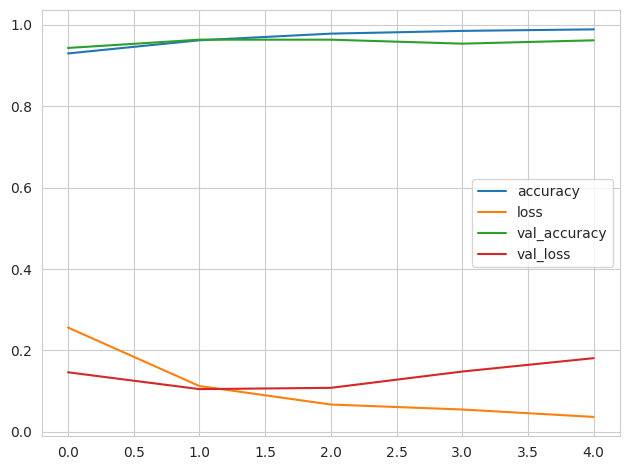

In [42]:
batch_size = 128
epochs = 5

history = model.fit(X_train.values, tf.cast(y_train.values, tf.int32),
                    validation_data=(X_valid.values, tf.cast(y_valid.values, tf.int32)),
                    callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [43]:
# Load the best setup
model.load_weights("best.weights.h5")

In [44]:
y_pred = model.predict(X_test.values).ravel()

200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step


## Sigmoid function gives us real number in range <0, 1>.

In [45]:
y_pred[:10]

array([5.63050294e-03, 3.66959795e-02, 1.19675742e-02, 5.59990220e-02,
       7.02522593e-05, 3.43778811e-05, 1.15806386e-01, 3.64783034e-02,
       9.58490968e-02, 1.31842783e-02], dtype=float32)

## We need to map this values to discreet classes 0 and 1

In [46]:
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

In [47]:
y_pred[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# The accuracy is not the best metric in the imbalanced situation - you already know the reason 🙂
* There are many more metrics we can use and one of the most common in this situation is the F1 Score, see [this](https://en.wikipedia.org/wiki/F-score) and [this](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/) for more info

In [48]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.9582355701548568

In [49]:
f1_score(y_true=y_test, y_pred=y_pred)

0.6454183266932271

In [50]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5945
           1       0.80      0.54      0.65       448

    accuracy                           0.96      6393
   macro avg       0.88      0.77      0.81      6393
weighted avg       0.95      0.96      0.95      6393



<Axes: >

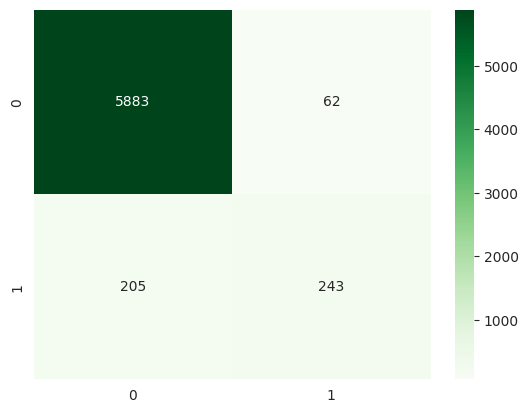

In [51]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), annot=True, cmap='Greens', fmt='.0f')

# Do we need to train our own embedding from scratch? 🤔
* 💡 There are multiple embeddings available online which were trained on very large corpuses e.g. Wikipedia
* Good examples are Word2Vec, Glove or FastText
    * These embeddings contains fixed length vectors for words in the vocabulary

* We will use GloVe embedding with 50 dimensional embedding vectors
    * For more details see [this](https://nlp.stanford.edu/projects/glove/)
* You can download zip with vectors from [http://nlp.stanford.edu/data/glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip) ~ 800 MB

### 📌 Beware that the original text corpus was more general than the specific social media text data
* 💡 So if you deal with very specific domains it may be beneficial to train your own embedding or at least fine tune existing one in the end

# We need to download the embedding files
~~~
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
~~~

* 💡50 dims GLOVE is also avaiable at https://ai.vsb.cz/downloads/glove.6B.50d.txt

# First we need to load the file to memory and create embedding dictionary

In [52]:
if not os.path.exists('glove.6B.zip') and not os.path.exists('glove.6B.50d.txt'):
    print("Downloading GloVe embeddings...")
    !wget http://nlp.stanford.edu/data/glove.6B.zip
else:
    print("GloVe embeddings already downloaded.")

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
--2025-03-29 15:30:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-29 15:30:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-29 15:30:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [53]:
if os.path.exists('glove.6B.zip') and not os.path.exists('glove.6B.50d.txt'):
    print("Extracting GloVe embeddings...")
    !unzip -q glove.6B.zip
else:
    print("GloVe embeddings already extracted.")

Extracting GloVe embeddings...
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [54]:
path_to_glove_file = 'glove.6B.50d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


## 💡 This is how the embedding latent vector looks like for the word `analysis`

In [55]:
embeddings_index['analysis']

array([ 0.47168 ,  0.25095 ,  0.078363,  0.33009 ,  0.32782 ,  0.47325 ,
        0.16805 , -0.99997 ,  0.8607  ,  0.018286, -0.022716, -0.16986 ,
       -0.33896 ,  0.10096 , -0.29278 , -0.18954 ,  0.063336, -0.64536 ,
       -0.098547, -0.46883 ,  0.26338 , -0.063779,  0.51437 , -0.34739 ,
        0.26537 , -0.58654 , -1.2527  , -0.20557 , -0.31604 ,  0.59308 ,
        2.8329  , -1.2396  , -0.23409 , -1.66    ,  0.047692, -0.23141 ,
       -0.14241 ,  0.74129 ,  0.69887 ,  0.14877 ,  0.6547  , -0.29812 ,
        0.10476 ,  0.56112 , -0.015528,  0.099004,  1.3858  ,  1.8129  ,
        0.3804  ,  0.83921 ], dtype=float32)

In [56]:
embeddings_index['analysis'].shape

(50,)

# 🚀 Our goal is to use the pre-trained embedding in our model
* We need to get the vocabulary from the `TextVectorization` layer and the integer indexes

In [57]:
embedding_dim = 50  # Embedding dimension -> GloVe 50
vocab_size = 10000  # Number of unique tokens in vocabulary
sequence_length = 20  # Output dimension after vectorizing - words in vectorited representation are independent

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Clean_text.values)

In [58]:
voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [59]:
voc[:10]

['',
 '[UNK]',
 np.str_('the'),
 np.str_('to'),
 np.str_('a'),
 np.str_('i'),
 np.str_('you'),
 np.str_('and'),
 np.str_('in'),
 np.str_('for')]

In [60]:
word_index['the']

2

In [61]:
embeddings_index['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

## Now we can create the embedding matrix
* We just need to map the `int` indices to the embedding vectors and save the mapping to the matrix
    * 💡 Each row of the matrix is a one token

In [62]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8504 words (1496 misses)


In [63]:
embedding_matrix[2]

array([ 4.18000013e-01,  2.49679998e-01, -4.12420005e-01,  1.21699996e-01,
        3.45270008e-01, -4.44569997e-02, -4.96879995e-01, -1.78619996e-01,
       -6.60229998e-04, -6.56599998e-01,  2.78430015e-01, -1.47670001e-01,
       -5.56770027e-01,  1.46579996e-01, -9.50950012e-03,  1.16579998e-02,
        1.02040000e-01, -1.27920002e-01, -8.44299972e-01, -1.21809997e-01,
       -1.68009996e-02, -3.32789987e-01, -1.55200005e-01, -2.31309995e-01,
       -1.91809997e-01, -1.88230002e+00, -7.67459989e-01,  9.90509987e-02,
       -4.21249986e-01, -1.95260003e-01,  4.00710011e+00, -1.85939997e-01,
       -5.22870004e-01, -3.16810012e-01,  5.92130003e-04,  7.44489999e-03,
        1.77780002e-01, -1.58969998e-01,  1.20409997e-02, -5.42230010e-02,
       -2.98709989e-01, -1.57490000e-01, -3.47579986e-01, -4.56370004e-02,
       -4.42510009e-01,  1.87849998e-01,  2.78489990e-03, -1.84110001e-01,
       -1.15139998e-01, -7.85809994e-01])

# Finall, we can use the GloVe embedding in the `Embedding` layer in our model
* 💡 Beware the `embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)` part
    * You say the model to use the GloVe vectors and that it can't modify them
    * 💡 You can also set the parameter `trainable=True` and do the fine-tuning of the embedding

In [64]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim,
                             embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = LSTM(64, activation='relu', return_sequences=True)(emb)
x = GRU(64, activation='relu', return_sequences=False)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.AdamW(), loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy(name='accuracy')])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 20)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 20, 50)         │       500,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 64)         │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,773 (2.14 MB)

 Trainable params: 60,673 (237.00 KB)

 Non-trainable params: 500,100 (1.91 MB)

In [65]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 163ms/step - accuracy: 0.9311 - loss: 0.3158 - val_accuracy: 0.9335 - val_loss: 0.1659
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - accuracy: 0.9335 - loss: 0.1809 - val_accuracy: 0.9437 - val_loss: 0.1570
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.9434 - loss: 0.1590 - val_accuracy: 0.9492 - val_loss: 0.1439
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.9492 - loss: 0.1448 - val_accuracy: 0.9535 - val_loss: 0.1390
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - accuracy: 0.9538 - loss: 0.1363 - val_accuracy: 0.9527 - val_loss: 0.1343


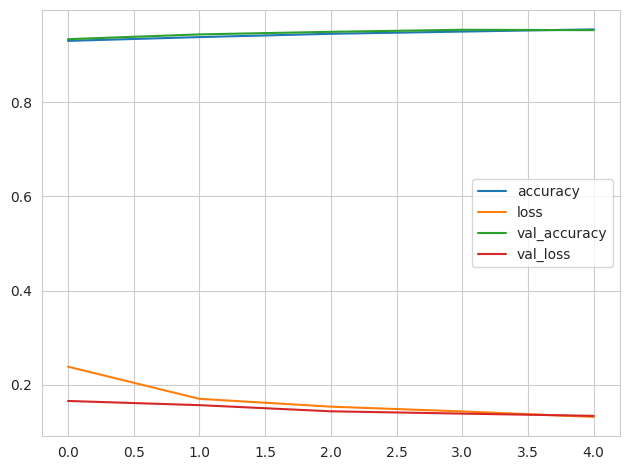

In [66]:
batch_size = 128
epochs = 5

history = model.fit(X_train.values, tf.cast(y_train.values, tf.float32),
                    validation_data=(X_valid.values, tf.cast(y_valid.values, tf.float32)),
                    callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [67]:
# Load the best setup
model.load_weights("best.weights.h5")

# 🔎 Which model is better?
* The one using pre-trained embedding or the one that we've trained from scrath?
* 🔎 Why?

In [68]:
y_pred = model.predict(X_test.values).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}')
print(f'F1 Score: {f1_score(y_true=y_test, y_pred=y_pred)}')

200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step
Accuracy: 0.9435319881119975
F1 Score: 0.5470514429109159


# ✅  Tasks for the lecture (2p)
* Try to fine-tune and switch the GloVe embedding and compare the models
    * Fine-tune GloVe 50 embedding - **(1p)**
    * Use GloVe 100 or higher dimentional embbeding - **(1p)**
    * 🔎 Is it any different according to the **F1-Score**?

# 🚀 There is a competition for bonus points this week! 
* Everyone who will send me a correct solution will be included in the F1 - Score toplist
    * 📌 **Send me a link to the notebook, not the .ipynb file (💡 e-mail filter issue)!**
* **Deadline for the competition submission is Sunday 30th at 15:00**
    * The toplist will be publicly available
* There is no limitation in used layers (LSTM, CNN, ...), optimizers and so on
    * 💡 You can use any model architecture from the internet including transfer learning
* The test set is the same as the one that we used in the lecture
    * 💡 It is marked with 🎯 in the notebook
* ⚡ The winner with the best **F1-Score** on test set will be awarded with **10 bonus points**

## 📌 The only limitation is that the model has to be trained/fine-tuned on Colab/Kaggle/Your machine so online sentiment scoring services or REST-API LLMs are forbidden!

![Meme03](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_06_meme_03.png?raw=true)


# Tasks

## Helper functions

### Time tracking

In [69]:
class TimeTrackerTrain:
    def __enter__(self):
        self.start_time = time.time()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end_time = time.time()
        self.execution_time = self.end_time - self.start_time
        minutes = self.execution_time // 60
        seconds = self.execution_time % 60
        print(f"Training time: {minutes:.0f} minutes and {seconds:.2f} seconds")

### Load GloVe embeddings

In [70]:
def load_glove_embeddings(dimension=50):
    if dimension not in [50, 100, 200, 300]:
        raise ValueError("Dimension must be one of [50, 100, 200, 300]")

    path_to_glove_file = f'glove.6B.{dimension}d.txt'

    print(f"Loading GloVE embeddings from {path_to_glove_file}...")
    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print(f"Loaded {len(embeddings_index)} word vectors.")
    return embeddings_index

### Create embedding matrix

In [71]:
def create_embedding_matrix(embeddings_index, vect_layer, embedding_dim):
    voc = vect_layer.get_vocabulary()
    word_index = dict(zip(voc, range(len(voc))))

    num_tokens = len(voc) + 2
    hits = 0
    misses = 0

    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

    print(f"Converted {hits} words ({misses} misses)")
    return embedding_matrix, num_tokens

### Create model with GloVe embedding

In [72]:
def create_model(vect_layer, embedding_matrix, num_tokens, embedding_dim, trainable=False):
    input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
    x_v = vect_layer(input_layer)
    emb = keras.layers.Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=trainable
    )(x_v)

    x = LSTM(64, activation='relu', return_sequences=True)(emb)
    x = GRU(64, activation='relu', return_sequences=False)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(64, 'relu')(x)
    x = keras.layers.Dense(32, 'relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    output_layer = keras.layers.Dense(1, 'sigmoid')(x)

    model = keras.Model(input_layer, output_layer)
    model.compile(
        optimizer=keras.optimizers.AdamW(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name='accuracy')]
    )

    return model

### Train model

In [73]:
def train_model(model, X_train, y_train, X_valid, y_valid, model_name, epochs=5, batch_size=128):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'weights/{model_name}_best.weights.h5',
        save_weights_only=True,
        monitor='val_loss',
        mode='auto',
        save_best_only=True
    )

    print(f"Training model {model_name}...")
    history = model.fit(
        X_train.values,
        tf.cast(y_train.values, tf.float32),
        validation_data=(X_valid.values, tf.cast(y_valid.values, tf.float32)),
        callbacks=[model_checkpoint_callback],
        epochs=epochs,
        batch_size=batch_size
    )

    model.load_weights(f'weights/{model_name}_best.weights.h5')

    return history

### Evaluate model

In [74]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test.values).ravel()
    y_pred_binary = [1 if x >= 0.5 else 0 for x in y_pred]

    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_binary)
    f1 = f1_score(y_true=y_test, y_pred=y_pred_binary)

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_true=y_test, y_pred=y_pred_binary))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred_binary),
                annot=True, cmap='Greens', fmt='.0f')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return {
        'accuracy': accuracy,
        'f1': f1,
        'model_name': model_name
    }

### Run single experiment

In [75]:
def run_single_experiment(X_train, y_train, X_valid, y_valid, X_test, y_test,
                          embedding_dim=50, trainable=False,
                          vocab_size=10000, sequence_length=20):
    vect_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=sequence_length
    )
    vect_layer.adapt(df.Clean_text.values)

    embeddings_index = load_glove_embeddings(embedding_dim)

    embedding_matrix, num_tokens = create_embedding_matrix(
        embeddings_index, vect_layer, embedding_dim
    )

    model_name = f"glove_{embedding_dim}d_{'trainable' if trainable else 'fixed'}"

    model = create_model(
        vect_layer=vect_layer,
        embedding_matrix=embedding_matrix,
        num_tokens=num_tokens,
        embedding_dim=embedding_dim,
        trainable=trainable
    )

    with TimeTrackerTrain():
        history = train_model(
            model=model,
            X_train=X_train,
            y_train=y_train,
            X_valid=X_valid,
            y_valid=y_valid,
            model_name=model_name
        )

    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.title(f"Training History - {model_name}")
    plt.tight_layout()
    plt.show()

    result = evaluate_model(
        model=model,
        X_test=X_test,
        y_test=y_test,
        model_name=model_name
    )

    return model, result, history

## Task 1 - GloVe embedding experiments

### GloVe 50d, non-trainable embedding

Loading GloVE embeddings from glove.6B.50d.txt...
Loaded 400000 word vectors.
Converted 8504 words (1496 misses)
Training model glove_50d_fixed...
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 161ms/step - accuracy: 0.9261 - loss: 0.3451 - val_accuracy: 0.9441 - val_loss: 0.1626
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - accuracy: 0.9415 - loss: 0.1691 - val_accuracy: 0.9425 - val_loss: 0.1643
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9460 - loss: 0.1615 - val_accuracy: 0.9507 - val_loss: 0.1438
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.9497 - loss: 0.1463 - val_accuracy: 0.9539 - val_loss: 0.1356
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 177ms/step - accuracy: 0.9563 - loss: 0.1268 - val_accuracy: 0.9511 - val_loss: 0.1341
Training time: 2 minutes and 27.74 seconds


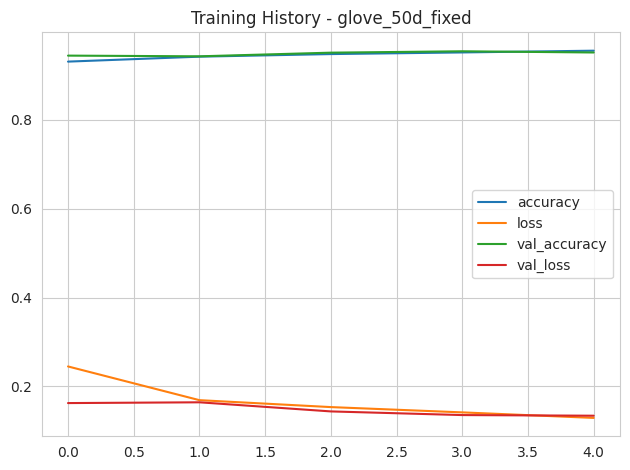

200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step
Model: glove_50d_fixed
Accuracy: 0.9473
F1 Score: 0.5718
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5945
           1       0.66      0.50      0.57       448

    accuracy                           0.95      6393
   macro avg       0.81      0.74      0.77      6393
weighted avg       0.94      0.95      0.94      6393



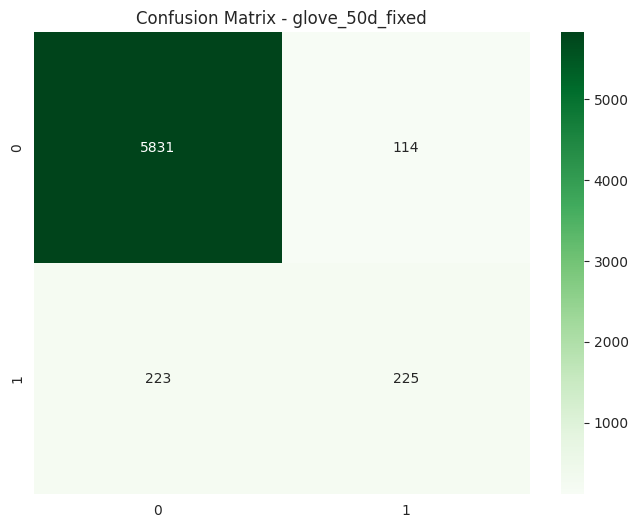

In [76]:
model_50d_fixed, result_50d_fixed, history_50d_fixed = run_single_experiment(
    X_train, y_train, X_valid, y_valid, X_test, y_test,
    embedding_dim=50, trainable=False
)

### GloVe 50d, trainable embedding

Loading GloVE embeddings from glove.6B.50d.txt...
Loaded 400000 word vectors.
Converted 8504 words (1496 misses)
Training model glove_50d_trainable...
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 175ms/step - accuracy: 0.9025 - loss: 0.3243 - val_accuracy: 0.9445 - val_loss: 0.1497
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 34s 186ms/step - accuracy: 0.9486 - loss: 0.1397 - val_accuracy: 0.9542 - val_loss: 0.1291
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 193ms/step - accuracy: 0.9602 - loss: 0.1088 - val_accuracy: 0.9566 - val_loss: 0.1197
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 34s 188ms/step - accuracy: 0.9706 - loss: 0.0809 - val_accuracy: 0.9597 - val_loss: 0.1184
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 34s 186ms/step - accuracy: 0.9780 - loss: 0.0647 - val_accuracy: 0.9644 - val_loss: 0.1261
Training time: 2 minutes and 50.89 seconds


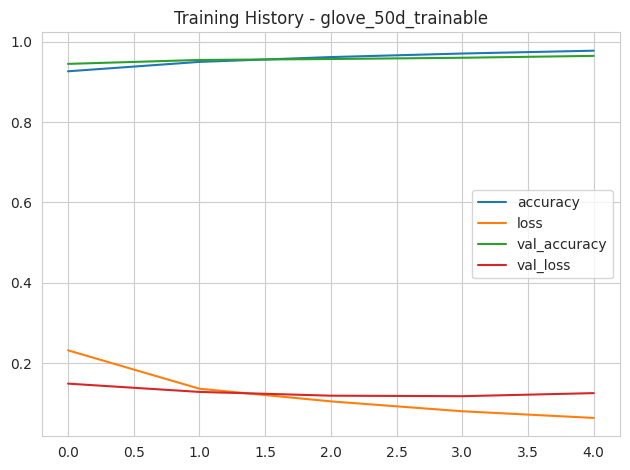

200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step
Model: glove_50d_trainable
Accuracy: 0.9517
F1 Score: 0.6578
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5945
           1       0.65      0.66      0.66       448

    accuracy                           0.95      6393
   macro avg       0.81      0.82      0.82      6393
weighted avg       0.95      0.95      0.95      6393



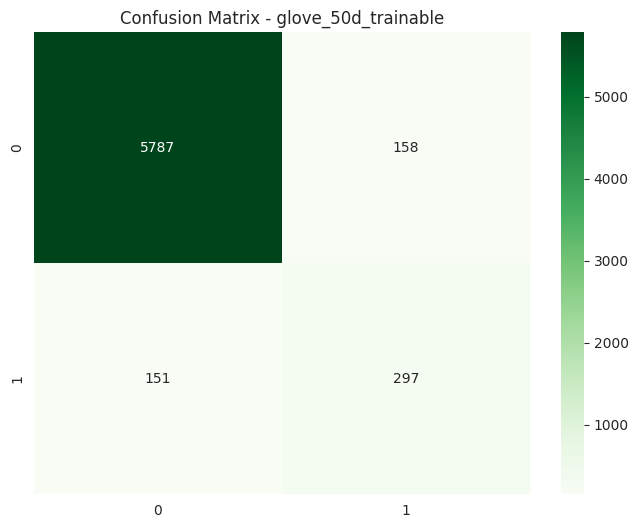

In [77]:
model_50d_trainable, result_50d_trainable, history_50d_trainable = run_single_experiment(
    X_train, y_train, X_valid, y_valid, X_test, y_test,
    embedding_dim=50, trainable=True
)

## Task 2 - fine tuning GloVe embedding for 100 dimensions and higher

### GloVe 100d, non-trainable embedding

Loading GloVE embeddings from glove.6B.100d.txt...
Loaded 400000 word vectors.
Converted 8504 words (1496 misses)
Training model glove_100d_fixed...
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 177ms/step - accuracy: 0.9228 - loss: 0.3528 - val_accuracy: 0.9390 - val_loss: 0.1586
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 177ms/step - accuracy: 0.9390 - loss: 0.1692 - val_accuracy: 0.9492 - val_loss: 0.1448
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 176ms/step - accuracy: 0.9477 - loss: 0.1507 - val_accuracy: 0.9554 - val_loss: 0.1305
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.9553 - loss: 0.1283 - val_accuracy: 0.9550 - val_loss: 0.1344
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 164ms/step - accuracy: 0.9594 - loss: 0.1160 - val_accuracy: 0.9531 - val_loss: 0.1272
Training time: 2 minutes and 37.01 seconds


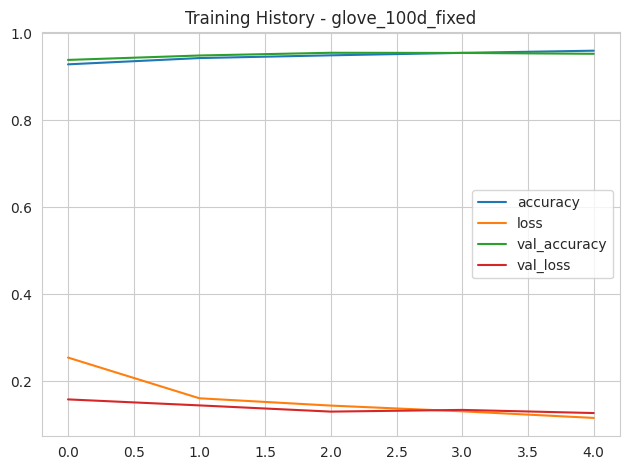

200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step
Model: glove_100d_fixed
Accuracy: 0.9487
F1 Score: 0.5015
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5945
           1       0.79      0.37      0.50       448

    accuracy                           0.95      6393
   macro avg       0.87      0.68      0.74      6393
weighted avg       0.94      0.95      0.94      6393



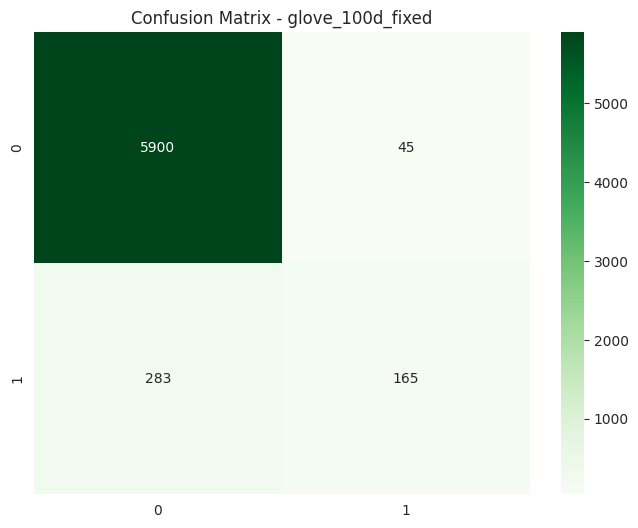

In [78]:
model_100d_fixed, result_100d_fixed, history_100d_fixed = run_single_experiment(
    X_train, y_train, X_valid, y_valid, X_test, y_test,
    embedding_dim=100, trainable=False
)

### GloVe 100d, trainable embedding

Loading GloVE embeddings from glove.6B.100d.txt...
Loaded 400000 word vectors.
Converted 8504 words (1496 misses)
Training model glove_100d_trainable...
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 34s 167ms/step - accuracy: 0.9042 - loss: 0.3168 - val_accuracy: 0.9511 - val_loss: 0.1387
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.9539 - loss: 0.1271 - val_accuracy: 0.9597 - val_loss: 0.1165
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.9676 - loss: 0.0944 - val_accuracy: 0.9625 - val_loss: 0.1096
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 162ms/step - accuracy: 0.9756 - loss: 0.0675 - val_accuracy: 0.9652 - val_loss: 0.1100
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.9821 - loss: 0.0531 - val_accuracy: 0.9652 - val_loss: 0.2072
Training time: 2 minutes and 30.53 seconds


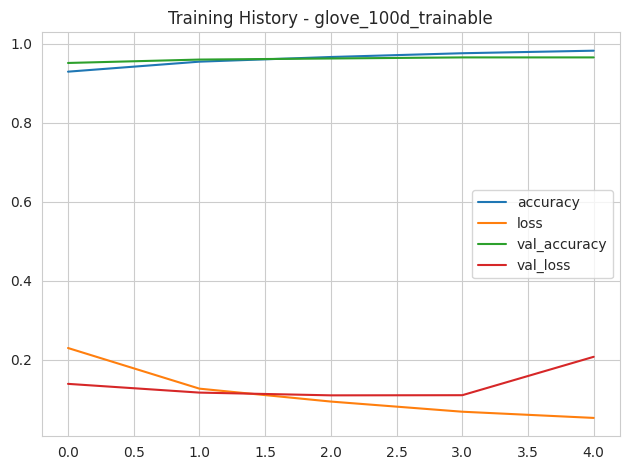

200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step
Model: glove_100d_trainable
Accuracy: 0.9553
F1 Score: 0.6554
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5945
           1       0.71      0.61      0.66       448

    accuracy                           0.96      6393
   macro avg       0.84      0.79      0.82      6393
weighted avg       0.95      0.96      0.95      6393



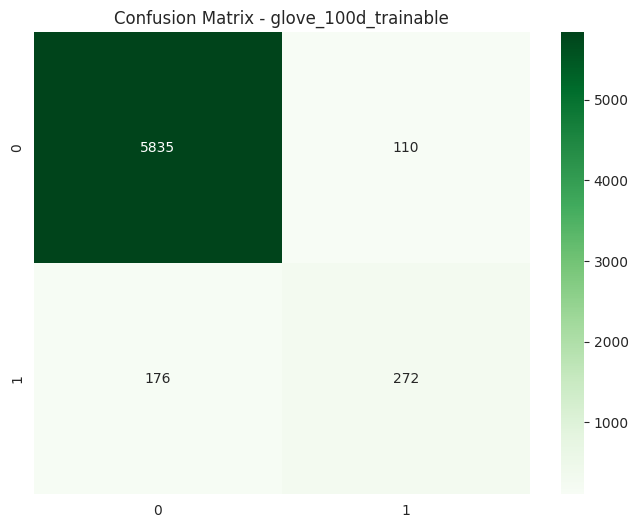

In [79]:
model_100d_trainable, result_100d_trainable, history_100d_trainable = run_single_experiment(
    X_train, y_train, X_valid, y_valid, X_test, y_test,
    embedding_dim=100, trainable=True
)

### Glove 200d, non-trainable embedding

Loading GloVE embeddings from glove.6B.200d.txt...
Loaded 400000 word vectors.
Converted 8504 words (1496 misses)
Training model glove_200d_fixed...
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 33s 158ms/step - accuracy: 0.9090 - loss: 0.3224 - val_accuracy: 0.9488 - val_loss: 0.1433
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 157ms/step - accuracy: 0.9475 - loss: 0.1546 - val_accuracy: 0.9515 - val_loss: 0.1356
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 157ms/step - accuracy: 0.9544 - loss: 0.1332 - val_accuracy: 0.9562 - val_loss: 0.1206
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 159ms/step - accuracy: 0.9613 - loss: 0.1119 - val_accuracy: 0.9566 - val_loss: 0.1352
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.9690 - loss: 0.0954 - val_accuracy: 0.9585 - val_loss: 0.1342
Training time: 2 minutes and 26.15 seconds


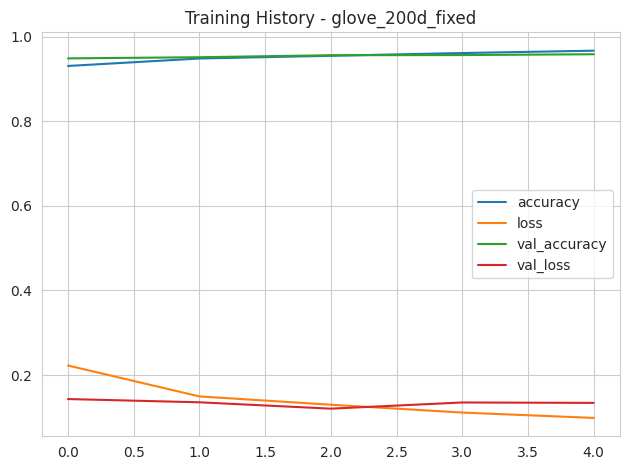

200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step
Model: glove_200d_fixed
Accuracy: 0.9504
F1 Score: 0.5931
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5945
           1       0.70      0.52      0.59       448

    accuracy                           0.95      6393
   macro avg       0.83      0.75      0.78      6393
weighted avg       0.95      0.95      0.95      6393



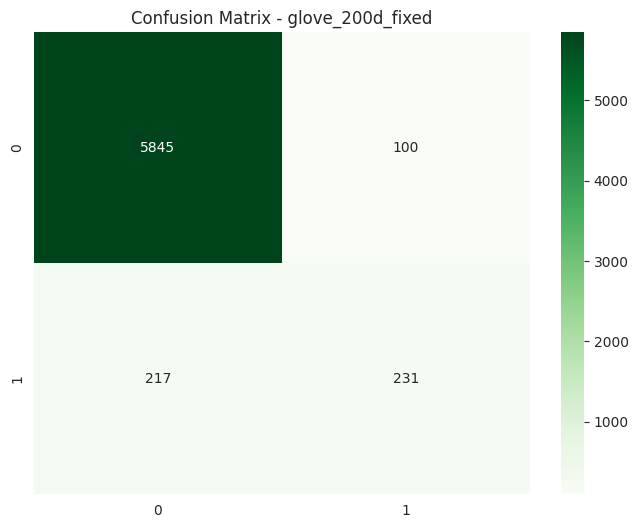

In [80]:
model_200d_fixed, result_200d_fixed, history_200d_fixed = run_single_experiment(
    X_train, y_train, X_valid, y_valid, X_test, y_test,
    embedding_dim=200, trainable=False
)

### GloVe 200d, trainable embedding

Loading GloVE embeddings from glove.6B.200d.txt...
Loaded 400000 word vectors.
Converted 8504 words (1496 misses)
Training model glove_200d_trainable...
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 173ms/step - accuracy: 0.9086 - loss: 0.3149 - val_accuracy: 0.9542 - val_loss: 0.1278
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - accuracy: 0.9570 - loss: 0.1252 - val_accuracy: 0.9625 - val_loss: 0.1099
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.9741 - loss: 0.0755 - val_accuracy: 0.9656 - val_loss: 0.1106
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 164ms/step - accuracy: 0.9839 - loss: 0.0506 - val_accuracy: 0.9640 - val_loss: 0.1392
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - accuracy: 0.9899 - loss: 0.0321 - val_accuracy: 0.9605 - val_loss: 0.1638
Training time: 2 minutes and 33.14 seconds


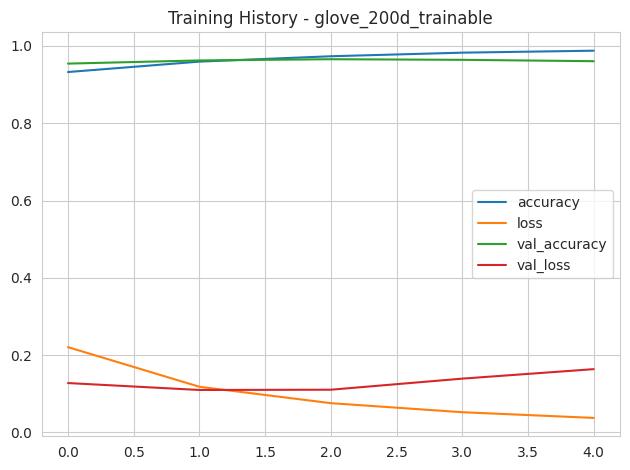

200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step
Model: glove_200d_trainable
Accuracy: 0.9551
F1 Score: 0.6168
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5945
           1       0.77      0.52      0.62       448

    accuracy                           0.96      6393
   macro avg       0.87      0.75      0.80      6393
weighted avg       0.95      0.96      0.95      6393



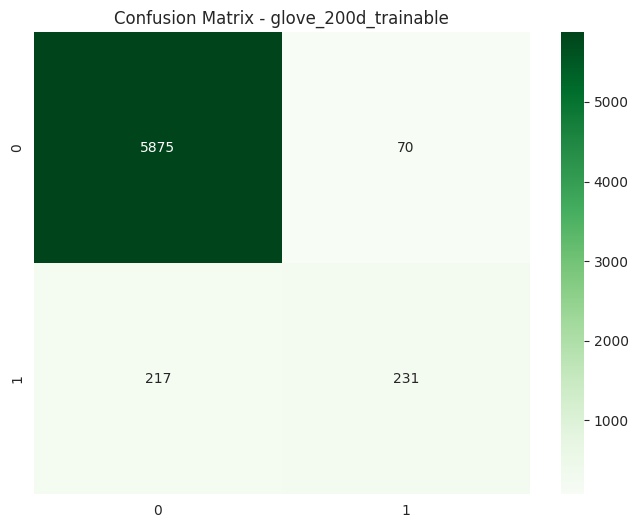

In [81]:
model_200d_trainable, result_200d_trainable, history_200d_trainable = run_single_experiment(
    X_train, y_train, X_valid, y_valid, X_test, y_test,
    embedding_dim=200, trainable=True
)

### GloVe 300d, non-trainable embedding

Loading GloVE embeddings from glove.6B.300d.txt...
Loaded 400000 word vectors.
Converted 8504 words (1496 misses)
Training model glove_300d_fixed...
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 160ms/step - accuracy: 0.9043 - loss: 0.3395 - val_accuracy: 0.9464 - val_loss: 0.1488
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 164ms/step - accuracy: 0.9483 - loss: 0.1509 - val_accuracy: 0.9507 - val_loss: 0.1421
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9571 - loss: 0.1240 - val_accuracy: 0.9546 - val_loss: 0.1304
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 163ms/step - accuracy: 0.9658 - loss: 0.1032 - val_accuracy: 0.9558 - val_loss: 0.1285
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - accuracy: 0.9719 - loss: 0.0845 - val_accuracy: 0.9582 - val_loss: 0.1342
Training time: 2 minutes and 39.80 seconds


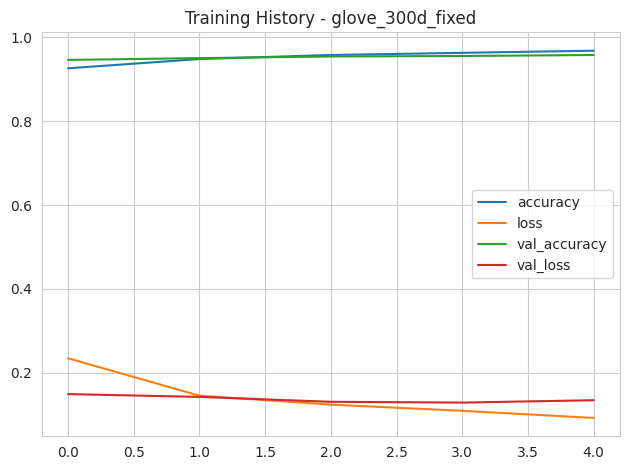

200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step
Model: glove_300d_fixed
Accuracy: 0.9523
F1 Score: 0.6023
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5945
           1       0.72      0.52      0.60       448

    accuracy                           0.95      6393
   macro avg       0.84      0.75      0.79      6393
weighted avg       0.95      0.95      0.95      6393



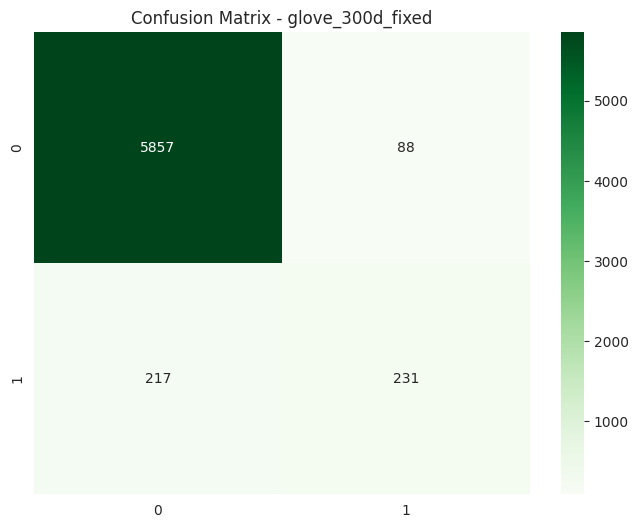

In [82]:
model_300d_fixed, result_300d_fixed, history_300d_fixed = run_single_experiment(
    X_train, y_train, X_valid, y_valid, X_test, y_test,
    embedding_dim=300, trainable=False
)

### GloVe 300d, trainable embedding

Loading GloVE embeddings from glove.6B.300d.txt...
Loaded 400000 word vectors.
Converted 8504 words (1496 misses)
Training model glove_300d_trainable...
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 34s 170ms/step - accuracy: 0.9292 - loss: 0.2703 - val_accuracy: 0.9539 - val_loss: 0.1226
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 176ms/step - accuracy: 0.9603 - loss: 0.1088 - val_accuracy: 0.9609 - val_loss: 0.1085
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 169ms/step - accuracy: 0.9755 - loss: 0.0740 - val_accuracy: 0.9679 - val_loss: 0.1069
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 168ms/step - accuracy: 0.9842 - loss: 0.0486 - val_accuracy: 0.9656 - val_loss: 0.1301
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 167ms/step - accuracy: 0.9877 - loss: 0.0410 - val_accuracy: 0.9671 - val_loss: 0.1499
Training time: 2 minutes and 37.29 seconds


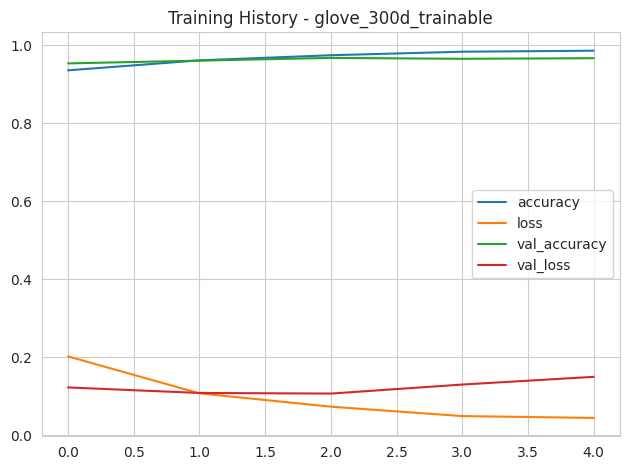

200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step
Model: glove_300d_trainable
Accuracy: 0.9575
F1 Score: 0.6723
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5945
           1       0.73      0.62      0.67       448

    accuracy                           0.96      6393
   macro avg       0.85      0.80      0.82      6393
weighted avg       0.95      0.96      0.96      6393



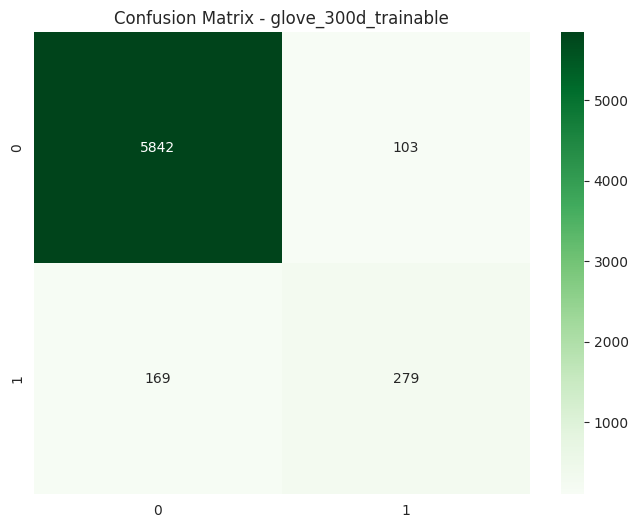

In [83]:
model_300d_trainable, result_300d_trainable, history_300d_trainable = run_single_experiment(
    X_train, y_train, X_valid, y_valid, X_test, y_test,
    embedding_dim=300, trainable=True
)

## Task results

In [84]:
results = [
    result_50d_fixed,
    result_50d_trainable,
    result_100d_fixed,
    result_100d_trainable,
    result_200d_fixed,
    result_200d_trainable,
    result_300d_fixed,
    result_300d_trainable
]
results_df = pd.DataFrame(results)
results_df.reset_index(drop=True, inplace=True)
results_df

,accuracy,f1,model_name
0,0.947286,0.571792,glove_50d_fixed
1,0.951666,0.657807,glove_50d_trainable
2,0.948694,0.501520,glove_100d_fixed
3,0.955264,0.655422,glove_100d_trainable
4,0.950415,0.593068,glove_200d_fixed
5,0.955107,0.616822,glove_200d_trainable
6,0.952292,0.602347,glove_300d_fixed
7,0.957453,0.672289,glove_300d_trainable


### Graphical comparison

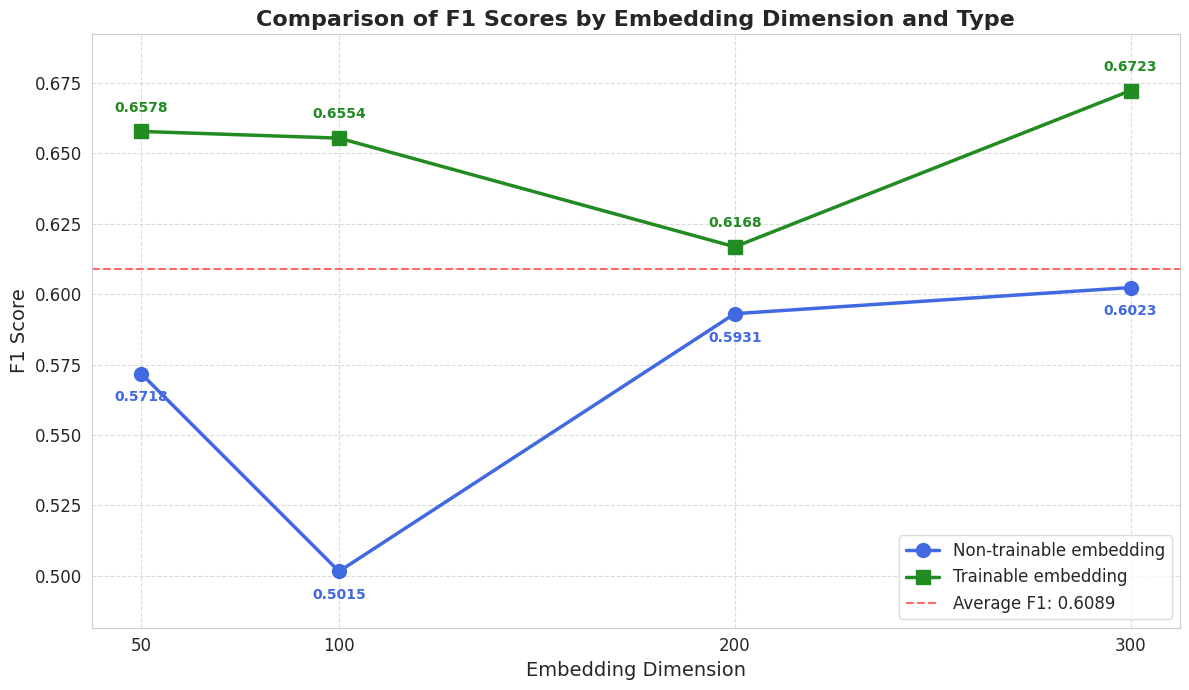

In [85]:
fixed_models = results_df[results_df['model_name'].str.contains('fixed')].copy()
trainable_models = results_df[results_df['model_name'].str.contains('trainable')].copy()

fixed_models['dimension'] = fixed_models['model_name'].str.extract(r'(\d+)').astype(int)
trainable_models['dimension'] = trainable_models['model_name'].str.extract(r'(\d+)').astype(int)

fixed_models = fixed_models.sort_values('dimension')
trainable_models = trainable_models.sort_values('dimension')

plt.figure(figsize=(12, 7))

plt.plot(fixed_models['dimension'], fixed_models['f1'], marker='o', markersize=10,
         linestyle='-', linewidth=2.5, color='royalblue',
         label='Non-trainable embedding')
plt.plot(trainable_models['dimension'], trainable_models['f1'], marker='s', markersize=10,
         linestyle='-', linewidth=2.5, color='forestgreen',
         label='Trainable embedding')

for i, dim in enumerate(fixed_models['dimension']):
    plt.text(dim, fixed_models['f1'].iloc[i] - 0.006, f"{fixed_models['f1'].iloc[i]:.4f}",
             ha='center', va='top', fontsize=10, color='royalblue', fontweight='bold')
    plt.text(dim, trainable_models['f1'].iloc[i] + 0.006, f"{trainable_models['f1'].iloc[i]:.4f}",
             ha='center', va='bottom', fontsize=10, color='forestgreen', fontweight='bold')

plt.title('Comparison of F1 Scores by Embedding Dimension and Type', fontsize=16, fontweight='bold')
plt.xlabel('Embedding Dimension', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(fixed_models['dimension'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

avg_f1 = results_df['f1'].mean()
plt.axhline(y=avg_f1, color='red', linestyle='--', alpha=0.6,
            label=f'Average F1: {avg_f1:.4f}')

plt.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='lightgray')
plt.tight_layout()

min_f1 = min(results_df['f1']) - 0.02
max_f1 = max(results_df['f1']) + 0.02
plt.ylim(min_f1, max_f1)

plt.show()